In [2]:
# from google.colab import drive
import tensorflow as tf
import numpy as np
import shutil
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
import torch
import timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
import torch
from transformers import ViTForImageClassification, AutoImageProcessor, AutoProcessor, AutoModelForImageClassification
import requests
from io import BytesIO

/Users/gechen/.pyenv/versions/3.10.6/envs/AI_Art_vs_Human_Art/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ Device: {DEVICE}")
if DEVICE.type == 'cpu':
    print("⚠️ WARNING: GPU not enabled! Training will be VERY slow.")
else:
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")


🖥️ Device: cpu
⚠️ WARNING: GPU not enabled! Training will be VERY slow.


In [17]:
# ---- config ----
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

LR = 1e-5
WEIGHT_DECAY = 0.01

train_dir = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/train'
val_dir ='/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/val'
BEST_DIR = '../models/practice_vit'


In [18]:
# ---- processor (get correct mean/std) ----
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
mean = processor.image_mean
std = processor.image_std

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [19]:
# ---- transforms ----
# 注意：ToTensor() 会把像素变成 [0,1]，这和 processor 的 rescale 等价
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(2),
    # transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tfms = transforms.Compose([
    #transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [45]:
# ---- datasets ----
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Classes: ['ai', 'nature']
class_to_idx: {'ai': 0, 'nature': 1}


In [46]:
for id,label in  enumerate(train_ds.classes):
  print(f"{id} | {label}")


0 | ai
1 | nature


In [47]:
# ---- model ---
# label2id / id2label
id2label = {id: label for id, label in enumerate(train_ds.classes)}
label2id = {label: id for id, label in enumerate(train_ds.classes)}
print("id2label:", id2label)
print("label2id:", label2id)

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 让分类头自动重建
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

id2label: {0: 'ai', 1: 'nature'}
label2id: {'ai': 0, 'nature': 1}


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([2, 768])
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([2])          

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [50]:
# ============================================
# TRAINING
# ============================================

print("\n" + "="*60)
print("TRAINING................")
print("="*60)

epochs = 10
train_losses = []
train_accs = []
val_accs = []
val_losses = []
patience = 3
best_val_acc = float('-inf')
os.makedirs(BEST_DIR, exist_ok=True)

for epoch in range(1,epochs+1):
    start_time = time.time()

    # Training
    model.train()
    train_correct = 0
    train_total = 0
    train_loss_sum = 0.0  # 按样本加权累计

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(DEVICE, non_blocking=True)
        batch_y = batch_y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(pixel_values=batch_X)
        logits = outputs.logits

        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        bs = batch_X.size(0)
        train_loss_sum += loss.item() * bs

        preds = logits.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += bs

    train_acc = train_correct / train_total
    avg_train_loss = train_loss_sum / train_total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            print("loop in")
            batch_X = batch_X.to(DEVICE, non_blocking=True)
            batch_y = batch_y.to(DEVICE, non_blocking=True)

            outputs = model(pixel_values=batch_X)
            logits = outputs.logits

            loss = criterion(logits, batch_y)

            bs = batch_X.size(0)
            val_loss_sum += loss.item() * bs

            preds = logits.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += bs

    val_acc = val_correct / val_total
    avg_val_loss = val_loss_sum / val_total

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)

    # Print metrics

    epoch_time = time.time() - start_time

    print(f"\nEpoch {epoch}/{epochs} - Time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")

    # save best model
    improved  = val_acc > best_val_acc + 1e-6
    if improved:
        best_val_acc = val_acc
        best_epoch = epoch
        wait = 0
        model.save_pretrained(BEST_DIR)
        processor.save_pretrained(BEST_DIR)
        print(f"best epoch updated to  {best_epoch}")
        print(f"best validation accuracy updated to {best_val_acc}")
        print(f"best model saved at path {BEST_DIR}")
    else:
        wait += 1
        print(f"val loss did not improve")

    # early stop
    if wait>patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Best epoch: {best_epoch}")
        print(f"Best validation loss: {best_val_acc}")
        break

print("\n✓ Training complete!")


TRAINING................
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop i

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to  1
best validation accuracy updated to 0.907
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to  2
best validation accuracy updated to 0.9305714285714286
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to  3
best validation accuracy updated to 0.9328571428571428
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to  4
best validation accuracy updated to 0.9347142857142857
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to  5
best validation accuracy updated to 0.9404285714285714
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to  8
best validation accuracy updated to 0.9407142857142857
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in
loop in


In [20]:
# 1) 加载
processor = AutoProcessor.from_pretrained(BEST_DIR)
model = AutoModelForImageClassification.from_pretrained(BEST_DIR).to(DEVICE)
model.eval()

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights: 100%|██████████| 200/200 [00:00<00:00, 1353.57it/s, Materializing param=vit.layernorm.weight]                                 


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [53]:
# ============================================
# COMPREHENSIVE EVALUATION
# ============================================

print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION")
print("="*60)

model.eval()

# Get predictions and probabilities
all_predictions = []
all_probabilities = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(DEVICE)
        outputs = model(pixel_values=batch_X)

        # Get probabilities
        probs = torch.softmax(outputs.logits, dim=1)
        all_probabilities.extend(probs[:, 0].cpu().numpy())  # Probability of AI class

        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)



COMPREHENSIVE EVALUATION


In [54]:
# ============================================
# METRICS
# ============================================

accuracy = accuracy_score(all_labels, all_predictions)
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_probabilities)

print(f"\n🎯 CORE METRICS:")
print(f"   Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"   Precision:         {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:            {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:          {f1:.4f}")
print(f"   ROC-AUC:           {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
tn, fp, fn, tp = cm.ravel()

print(f"\n🔍 CONFUSION MATRIX:")
print(f"   True Negatives (Nature → Nature):  {tn:4d}")
print(f"   False Positives (Nature → AI):     {fp:4d}")
print(f"   False Negatives (AI → Nature):     {fn:4d}")
print(f"   True Positives (AI → AI):          {tp:4d}")

# Per-class metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 CLASS-SPECIFIC PERFORMANCE:")
print(f"   Sensitivity (AI detection):     {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity (Nature detection): {specificity:.4f} ({specificity*100:.2f}%)")

# Classification Report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_predictions,
                            target_names=['Nature (Real)', 'AI'],
                            digits=4))



🎯 CORE METRICS:
   Accuracy:          0.9407 (94.07%)
   Balanced Accuracy: 0.9407 (94.07%)
   Precision:         0.9522 (95.22%)
   Recall:            0.9280 (92.80%)
   F1-Score:          0.9400
   ROC-AUC:           0.0152

🔍 CONFUSION MATRIX:
   True Negatives (Nature → Nature):  3337
   False Positives (Nature → AI):      163
   False Negatives (AI → Nature):      252
   True Positives (AI → AI):          3248

📈 CLASS-SPECIFIC PERFORMANCE:
   Sensitivity (AI detection):     0.9280 (92.80%)
   Specificity (Nature detection): 0.9534 (95.34%)

📋 DETAILED CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Nature (Real)     0.9298    0.9534    0.9415      3500
           AI     0.9522    0.9280    0.9400      3500

     accuracy                         0.9407      7000
    macro avg     0.9410    0.9407    0.9407      7000
 weighted avg     0.9410    0.9407    0.9407      7000



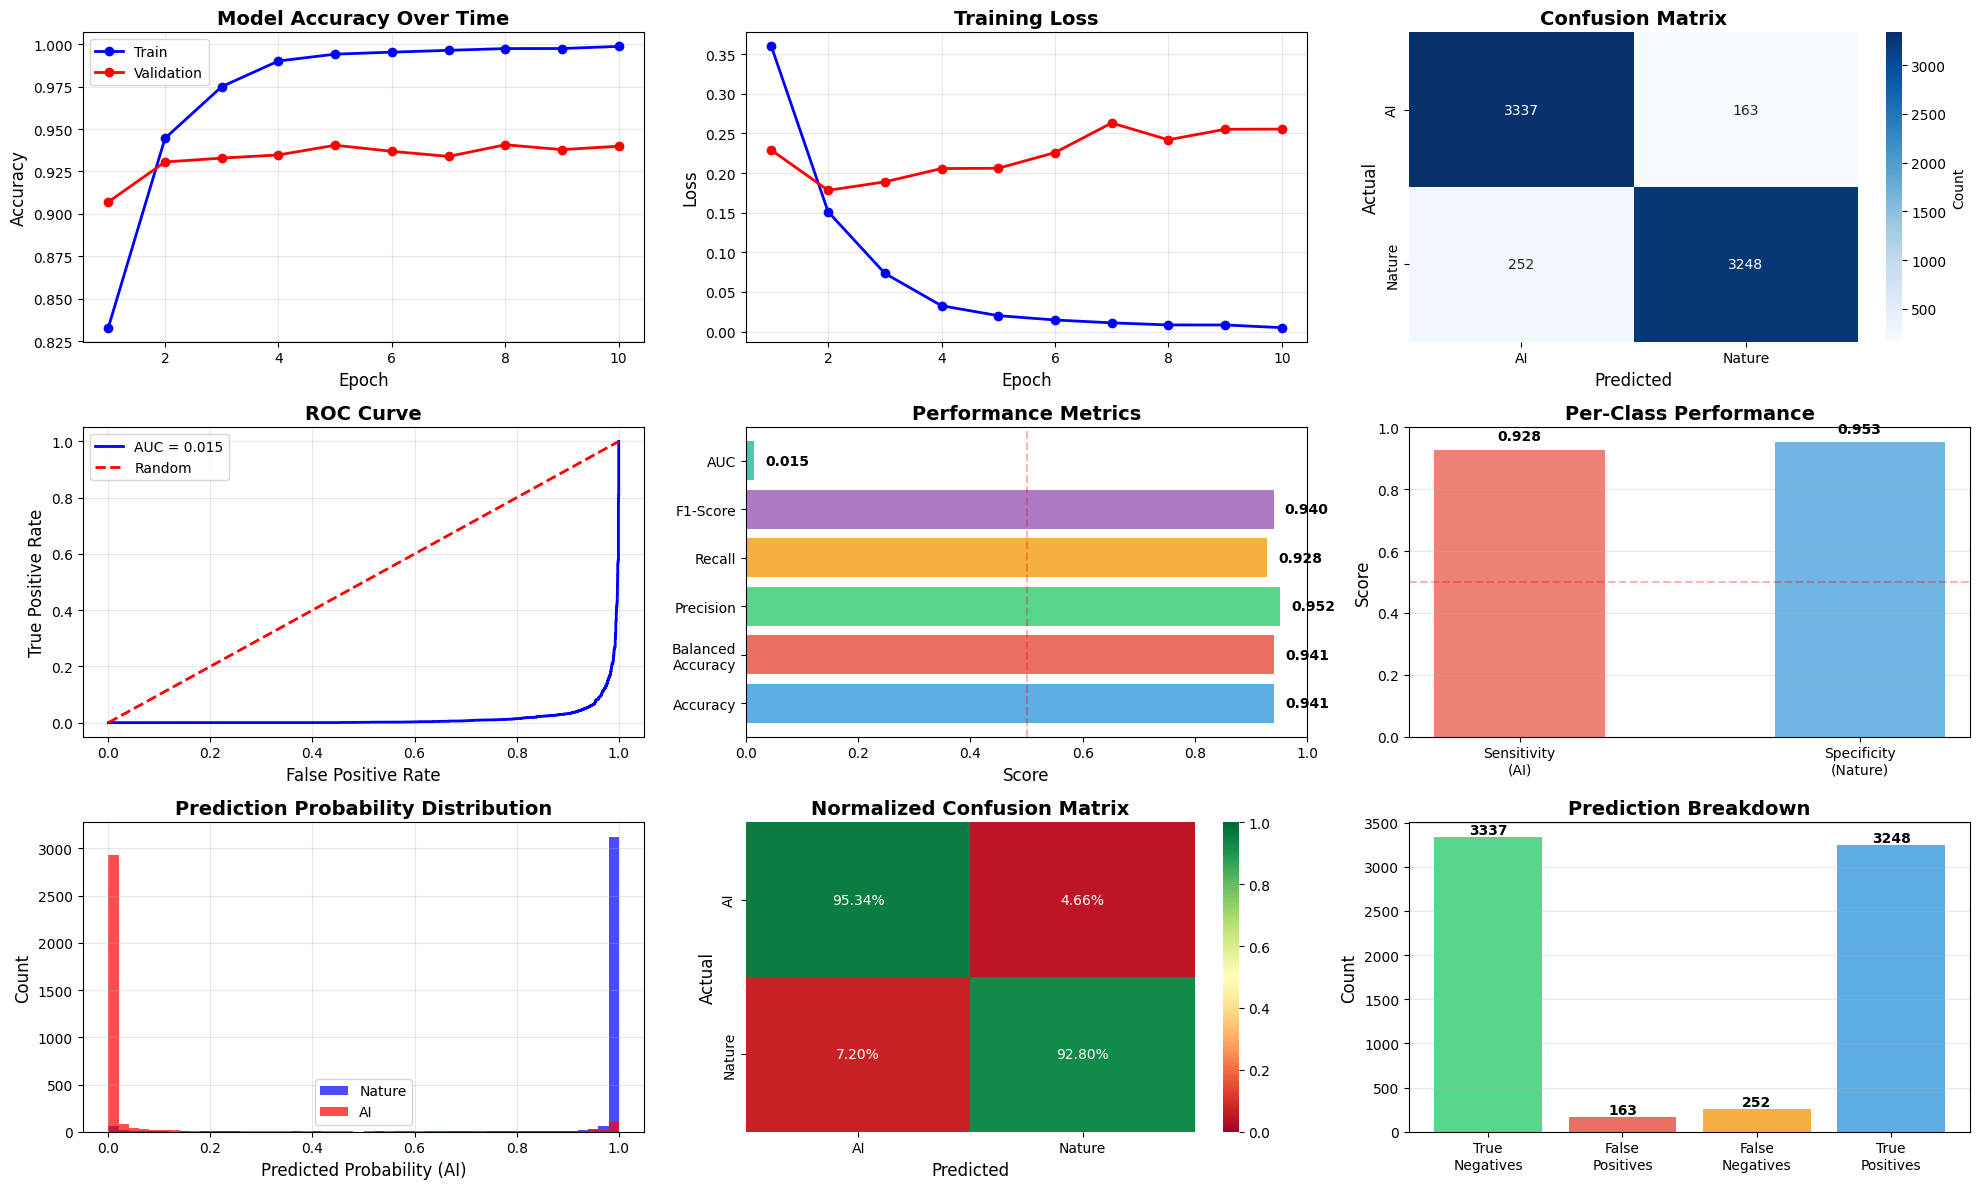

✓ Visualizations saved!


In [65]:
# ============================================
# VISUALIZATIONS
# ============================================

# print("\n📊 Creating visualizations...")

fig = plt.figure(figsize=(20, 12))

# # 1. Training History
ax1 = plt.subplot(3, 3, 1)
epochs_range = range(1, epochs + 1)
ax1.plot(epochs_range, train_accs, 'b-o', label='Train', linewidth=2)
ax1.plot(epochs_range, val_accs, 'r-o', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

 # 2. Loss Curve
ax2 = plt.subplot(3, 3, 2)
ax2.plot(epochs_range, train_losses, 'b-o', linewidth=2)
ax2.plot(epochs_range, val_losses, 'r-o', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# # 3. Confusion Matrix
ax3 = plt.subplot(3, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
              xticklabels=['AI', 'Nature'],
              yticklabels=['AI', 'Nature'],
              cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12)
ax3.set_xlabel('Predicted', fontsize=12)

# 4. ROC Curve
ax4 = plt.subplot(3, 3, 4)
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
ax4.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc:.3f}')
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Metrics Bar Chart
ax5 = plt.subplot(3, 3, 5)
metrics_names = ['Accuracy', 'Balanced\nAccuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [accuracy, balanced_acc, precision, recall, f1, auc]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
bars = ax5.barh(metrics_names, metrics_values, color=colors, alpha=0.8)
ax5.set_xlim(0, 1)
ax5.set_xlabel('Score', fontsize=12)
ax5.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax5.axvline(x=0.5, color='red', linestyle='--', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    ax5.text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')

# 6. Per-Class Performance
ax6 = plt.subplot(3, 3, 6)
class_metrics = ['Sensitivity\n(AI)', 'Specificity\n(Nature)']
class_values = [sensitivity, specificity]
class_colors = ['#e74c3c', '#3498db']
bars = ax6.bar(class_metrics, class_values, color=class_colors, alpha=0.7, width=0.5)
ax6.set_ylim(0, 1)
ax6.set_ylabel('Score', fontsize=12)
ax6.set_title('Per-Class Performance', fontsize=14, fontweight='bold')
ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
for bar, val in zip(bars, class_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 7. Prediction Distribution
ax7 = plt.subplot(3, 3, 7)
ax7.hist(all_probabilities[all_labels == 0], bins=50, alpha=0.7, label='Nature', color='blue')
ax7.hist(all_probabilities[all_labels == 1], bins=50, alpha=0.7, label='AI', color='red')
ax7.set_xlabel('Predicted Probability (AI)', fontsize=12)
ax7.set_ylabel('Count', fontsize=12)
ax7.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Normalized Confusion Matrix
ax8 = plt.subplot(3, 3, 8)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax8,
            xticklabels=['AI', 'Nature'],
            yticklabels=['AI', 'Nature'],
            vmin=0, vmax=1)
ax8.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
ax8.set_ylabel('Actual', fontsize=12)
ax8.set_xlabel('Predicted', fontsize=12)

# 9. Error Analysis
ax9 = plt.subplot(3, 3, 9)
error_types = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
error_counts = [tn, fp, fn, tp]
error_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']
bars = ax9.bar(error_types, error_counts, color=error_colors, alpha=0.8)
ax9.set_ylabel('Count', fontsize=12)
ax9.set_title('Prediction Breakdown', fontsize=14, fontweight='bold')
for bar, val in zip(bars, error_counts):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontweight='bold')
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/AI_vs_human/model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved!")

In [5]:
def get_image_from_url(path):
    img_size= (IMG_SIZE,IMG_SIZE)
    response = requests.get(url=path)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    img = img.resize(img_size)
    print(f"picture size : {img_size}; mode : {img.mode}")
    return img


def predict_image(path, val_tfms, model, device):
    model.eval()
    img = get_image_from_url(path)
    x = test_tfms(img).unsqueeze(0).to(device)  # (1,3,224,224)

    with torch.no_grad():
        logits = model(pixel_values=x).logits# (1,C)
        print(logits)
        probs = torch.softmax(logits, dim=1)[0]
        print(probs)# (C,)
        pred_id = int(probs.argmax().item())
        print(pred_id)
        pred_label = model.config.id2label[pred_id]
        confidence = float(probs[pred_id].item())

    return pred_label, confidence, probs.cpu().numpy()

In [ ]:
import glob

# Define the path to your image folder (use double backslashes for Windows paths)
folder_path = "../test_images"

# Get a list of all file paths matching the pattern
image_files = glob.glob(folder_path) #


['../test_images']

In [33]:
real_example = 'https://insider.si.edu/wp-content/uploads/2017/04/87500673_7cec21f38a_b.jpg'

In [40]:
ai_example = 'https://chatgpt.com/backend-api/estuary/content?id=file_000000008ae871f584001051e12156c0&cp=pri&ma=90000&ts=20509&p=igh&cid=1&sig=536d5c55d944fa4763b54dad1f8099d436f92fb61046456cfa4cb92de84be2a3'

In [4]:
label, conf, probs = predict_image(ai_example, val_tfms, model, DEVICE)
print("pred:", label, "conf:", conf)

NameError: name 'predict_image' is not defined

In [9]:
batch_dir = Path('../batch_predict')
from pathlib import Path
from PIL import Image


In [ ]:
# 只打开常见图像文件
for img_path in batch_dir.iterdir():
    if img_path.is_file() and img_path.suffix.lower() in ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.webp'):
        img_size = (IMG_SIZE,IMG_SIZE)
        img = Image.open(img_path)
        img = img.convert(mode="RGB")
        img = img.resize(img_size)

        model.eval()
        x = test_tfms(img).unsqueeze(0).to(DEVICE)  # (1,3,224,224)

        with torch.no_grad():
            logits = model(pixel_values=x).logits# (1,C)

            probs = torch.softmax(logits, dim=1)[0]

            pred_id = int(probs.argmax().item())

            pred_label = model.config.id2label[pred_id]
            confidence = float(probs[pred_id].item())
            print(pred_label,confidence)


nature 0.9999786615371704
ai 0.9894815683364868
nature 0.9993734955787659
nature 0.9879199266433716
ai 0.9982602000236511
nature 0.9993913173675537


download.jpeg nature 0.9999727010726929


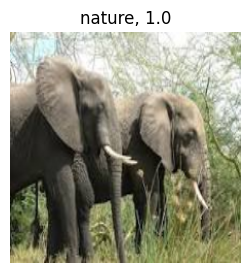

ChatGPT Image Feb 24, 2026, 08_39_41 PM.png ai 0.9997350573539734


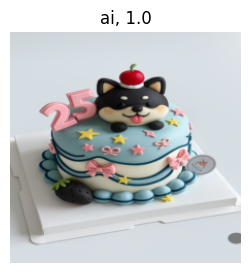

images.jpeg nature 0.9979019165039062


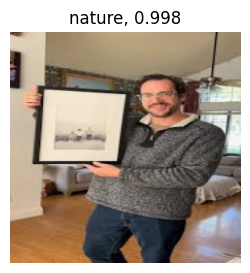

CMJ7852_1BLOG.jpg nature 0.9236776828765869


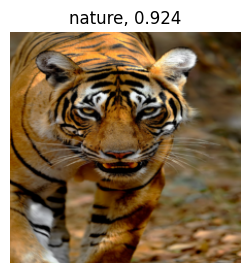

nature-sunset-tranquil-meadow-rural-scene-beauty-generative-ai.jpg ai 0.9993575215339661


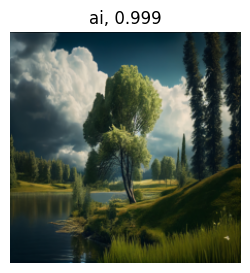

ChatGPT Image Feb 24, 2026, 08_39_21 PM.png nature 0.9843518137931824


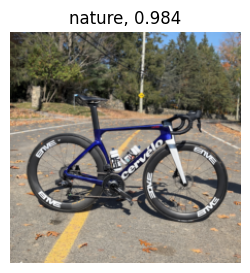

In [ ]:
from PIL import Image

img_size = (IMG_SIZE, IMG_SIZE)

model.to(DEVICE)
model.eval()

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp')

for img_path in batch_dir.iterdir():
    if not (img_path.is_file() and img_path.suffix.lower() in valid_exts):
        continue

    with Image.open(img_path) as img:
        img = img.convert("RGB").resize(img_size, resample=Image.BILINEAR)

    x = test_tfms(img).unsqueeze(0).to(DEVICE)  # (1,3,H,W)

    with torch.no_grad():
        logits = model(pixel_values=x).logits  # (1,C)
        probs = torch.softmax(logits, dim=1)[0]
        pred_id = int(probs.argmax().item())
        pred_label = model.config.id2label[pred_id]
        confidence = float(probs[pred_id].item())
        print(img_path.name, pred_label, confidence)

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(f"{pred_label}, {round(confidence,3)}")
    plt.axis("off")
    plt.show()
